In [7]:
# Specify keras model

import numpy as np
from keras.layers import Dense
from keras.models import Sequential


In [8]:
import gensim
import sklearn.datasets

from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn import metrics

In [10]:
# Create a dataframe containing all the labelled text data from Curation

import json
import time
import argparse
import os
import pandas as pd
from pandas.io.json import json_normalize

columns = ["Title", "PublishedDate","Body","Source_name","Source_url","Category"]
index = np.arange(1)
all_articles_df = pd.DataFrame(columns=columns, index=index)

for filename in os.listdir("./data/"):
    if filename.endswith(".json"):
        #with open(os.path.join("./data/", filename)) as f:
        #    content = f.read()
        
        # Load json as string
        articles = json.load(open(os.path.join("./data/", filename)))

        # Normalise (i.e. breakout) nested Sources into Title and Url fields
        norm_articles_json = json_normalize(articles, "Sources")
        sources_df = norm_articles_json[["Title", "Url"]].copy()

        # Rename columns to maintain consistency with training data
        new_sources_df = sources_df.rename(columns={"Title": "Source_name", "Url": "Source_url"})

        # Load original articles as Pandas dataframe
        articles_df = pd.read_json(open(os.path.join("./data/", filename)))

        # Select the other relevant columns
        cleaned_articles_df = articles_df[["Title", "PublishedDate", "Body"]].copy()

        # Concatenate the relevant columns with the normalised sources columns
        full_articles_df = pd.concat([cleaned_articles_df, new_sources_df], axis = 1)

        # Drop rows containing NaNs
        full_articles_nn = full_articles_df.dropna(how="any")

        label = os.path.splitext(filename)[0]
        category = []
        for row in full_articles_nn['Body']:
            category.append(label)
        full_articles_nn["Category"] = category
        all_articles_df = pd.concat([all_articles_df, full_articles_nn], axis=0)
        
all_articles_df = all_articles_df.drop([0])
# all_articles_df


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# Confirm that we have a balanced dataset
# Note: data was randomly shuffled in our BigQuery query

all_articles_df["Category"].value_counts()

cpr_articles         6846
blackswans           4837
batterytech          4092
financialservices    3986
carboneradication    3690
sharingeconomy       3574
digitalads           2920
internetofthings     2627
property             2132
digitalhealth        1943
digitalcurrency      1914
ai                   1722
blockchain           1650
educationtech        1555
Name: Category, dtype: int64

In [5]:
# Shuffle and simplify the dataframe in preparation for doing a train/test split

shuffled_df = all_articles_df.sample(frac=1).reset_index(drop=True)
shuffled_df = shuffled_df.drop(["PublishedDate", "Source_name", "Source_url"], axis=1)
# shuffled_df

In [107]:
# Split data into train and test
train_size = int(len(shuffled_df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(shuffled_df) - train_size))

Train size: 34790
Test size: 8698


In [108]:
train_posts = shuffled_df["Body"][:train_size]
train_tags = shuffled_df["Category"][:train_size]

test_posts = shuffled_df["Body"][train_size:]
test_tags = shuffled_df["Category"][train_size:]

Now we have our data, the first step is to try it on a simple multi-layer perceptron network, as follows.

In [109]:
import keras.preprocessing.text as text

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [120]:
x_train

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.]])

In [113]:
# Use sklearn utility to convert label strings to numbered index
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [115]:
from tensorflow.contrib.keras.python.keras import utils

# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [121]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [122]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (34790, 1000)
x_test shape: (8698, 1000)
y_train shape: (34790, 14)
y_test shape: (8698, 14)


In [124]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data

batch_size = 32
epochs = 2

In [125]:
# Build the model

model = Sequential()

Now we can add our input layer. add our input layer. The input layer will take the vocab_size arrays for each comment. We’ll specify this as a Dense layer in Keras, which means each neuron in this layer will be fully connected to all neurons in the next layer. We pass the Dense layer two parameters: the dimensionality of the layer’s output (number of neurons) and the shape of our input data. Choosing the number of dimensions requires some experimentation, and there is a lot of discussion on the best approach for doing this. It’s common to use a power of 2 as the number of dimensions, so we’ll start with 512. The number of rows in our input data will be the number of posts we’re feeding the model at each training step (called batch size), and the number of columns will be the size of our vocabulary. With that, we’re ready to define the Dense input layer. The activation function tells our model how to calculate the output of a layer. 

In [127]:
from keras.layers import Dense, Activation, Dropout

model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

In [128]:
# Define output layer (number of labels) and type of layer

model.add(Dense(num_classes))
model.add(Activation('softmax'))

To prepare our model for training, we need to call the compile method with the loss function we want to use, the type of optimizer, and the metrics our model should evaluate during training and testing. We’ll use the cross entropy loss function, since each of our comments can only belong to one post. The optimizer is the function our model uses to minimize loss. In this example we’ll use the Adam optimizer. 

In [129]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

To train our model, we’ll call the fit() method, pass it our training data and labels, the number of examples to process in each batch (batch size), how many times the model should train on our entire dataset (epochs), and the validation split. validation_split tells Keras what percentage of our training data to reserve for validation.

In [130]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 31311 samples, validate on 3479 samples
Epoch 1/2
31311/31311 [==============================] - 19s 607us/step - loss: 1.0382 - acc: 0.6674 - val_loss: 0.8556 - val_acc: 0.7160
Epoch 2/2
31311/31311 [==============================] - 18s 564us/step - loss: 0.6924 - acc: 0.7538 - val_loss: 0.8548 - val_acc: 0.7134


In [131]:
# Evaluate the accuracy of our trained model

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8698/8698 [==============================] - 1s 100us/step
Test score: 0.84577918631
Test accuracy: 0.70970338017


In [132]:
# Here's how to generate a prediction on individual examples

text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

<p>Fourteen US states, including Maryland, New Yor ...
Actual label:carboneradication
Predicted label: carboneradication

<p>B<strong>ank Mandiri</strong> is set to expand  ...
Actual label:cpr_articles
Predicted label: cpr_articles

<p>Qualcomm and Novartis have announced a partners ...
Actual label:digitalhealth
Predicted label: digitalhealth

Developers at Bristol-based Ovo Energy have built  ...
Actual label:internetofthings
Predicted label: internetofthings

<p>The Scottish and Southern Electricity Networks  ...
Actual label:batterytech
Predicted label: batterytech

<p>US director of national intelligence, James Cla ...
Actual label:internetofthings
Predicted label: internetofthings

<p>After executives of Samsung’s subsidiary compan ...
Actual label:digitalcurrency
Predicted label: digitalcurrency

Prop. F, or "the Airbnb law" being put forward in  ...
Actual label:property
Predicted label: sharingeconomy

<p>Clean-energy projects will struggle unless an e ...
Actual label:cpr_ar

In [133]:
# set up a one hot index of predicted values for our test
# data, for plotting

y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [135]:
import matplotlib.pyplot as plt

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

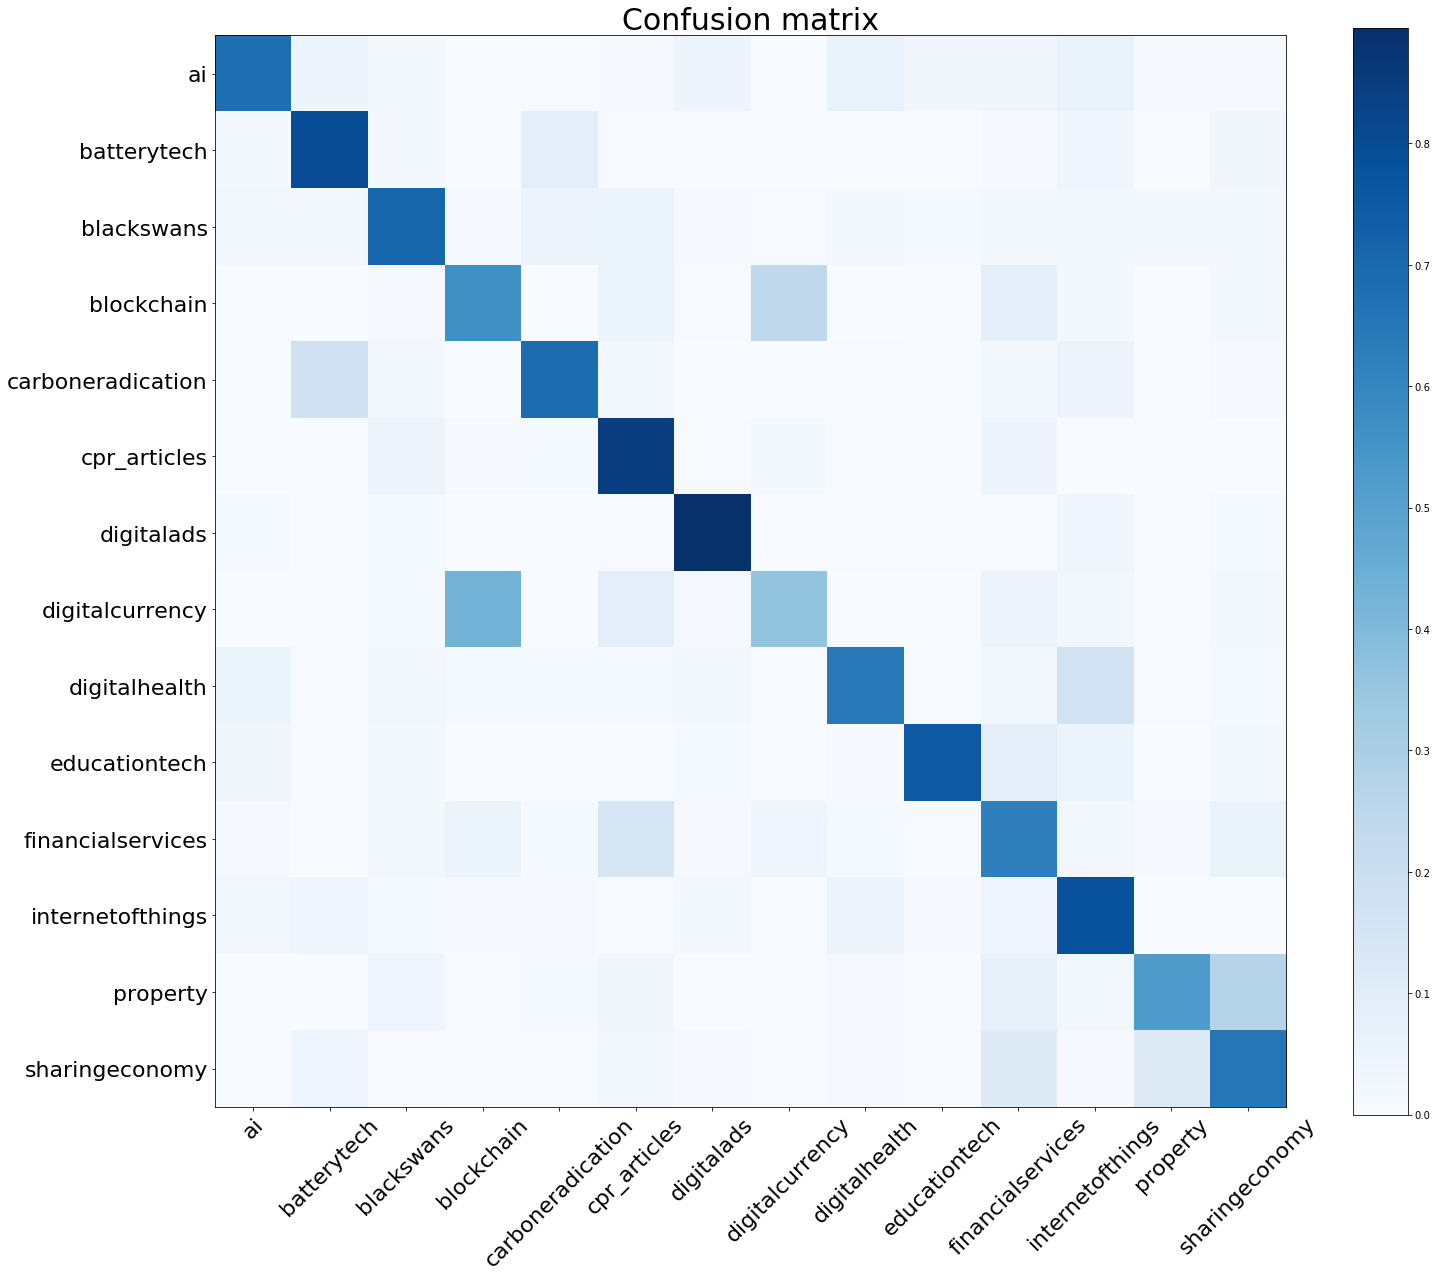

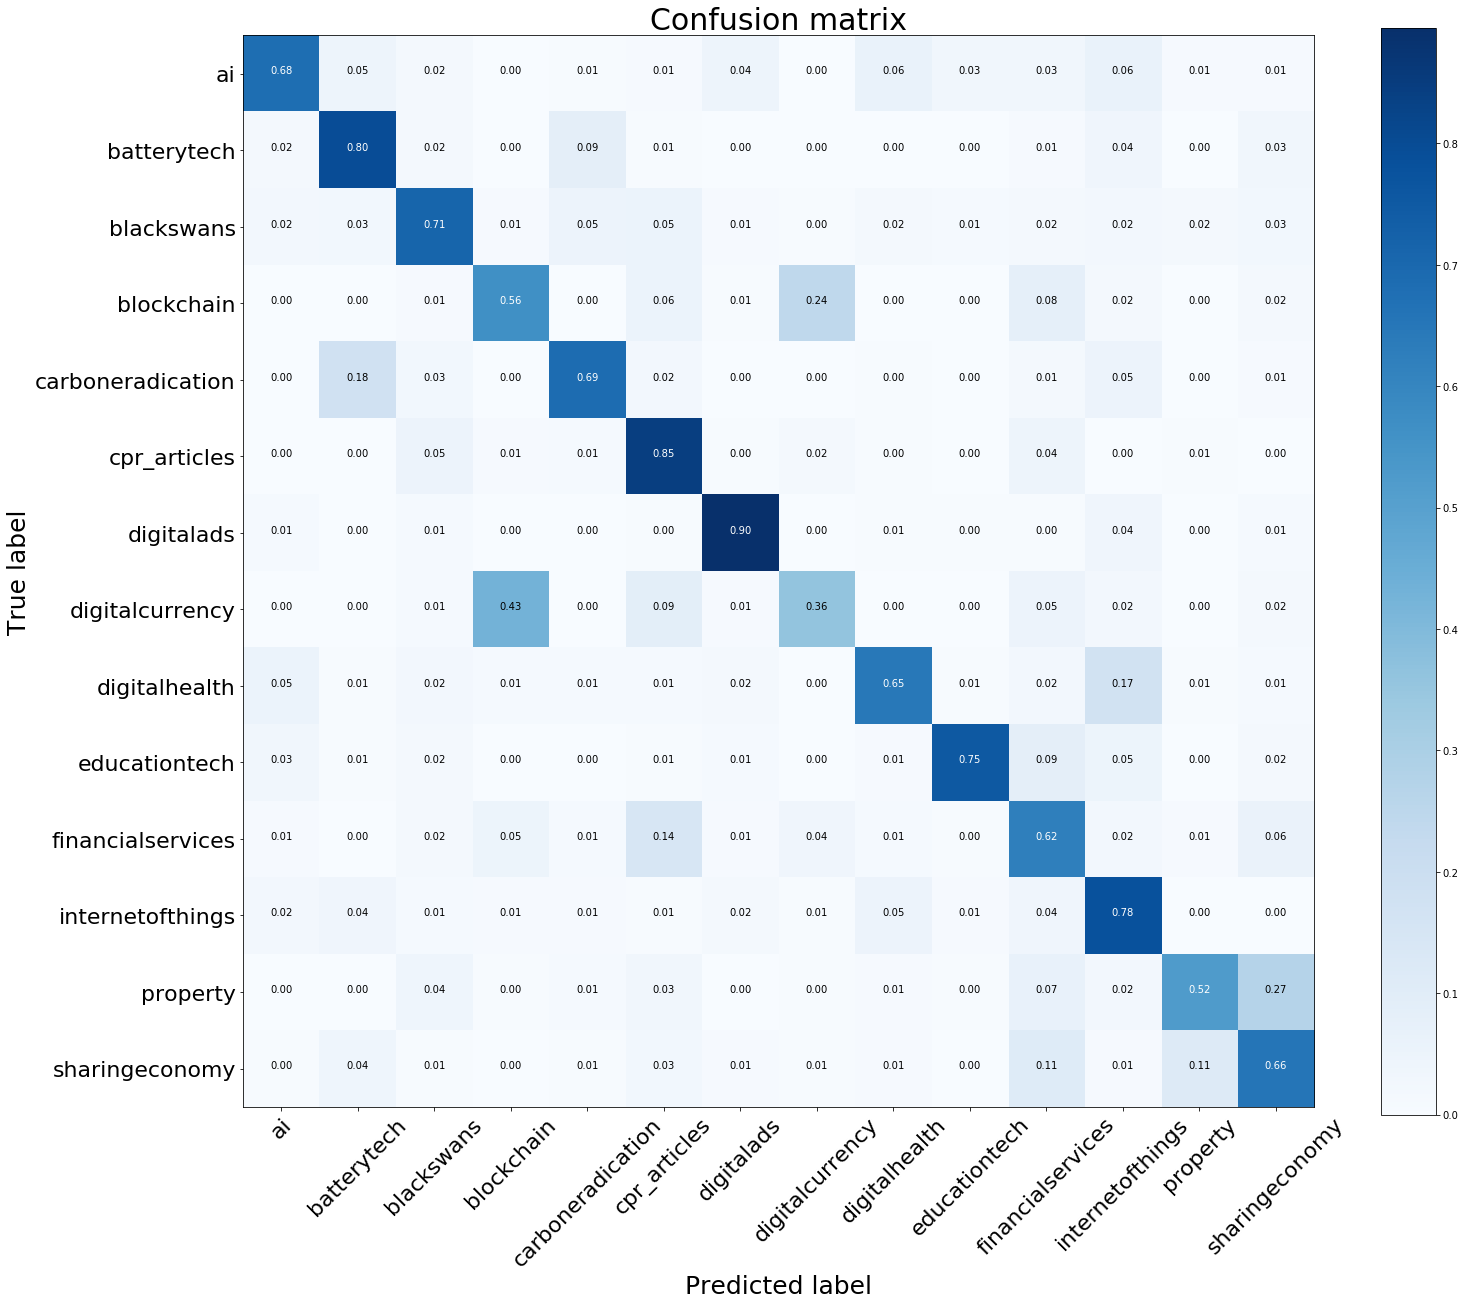

In [138]:
import itertools
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

This is pretty promising! The prediction accuracy of this first simple neural net is 0.70. That's not far off the prediction accuracy of the SVM based on ti-idf we looked at in the first Capstone project, which averaged 0.77, and is superior to the 0.64 achieved by the SVM based on doc2vec. However... we really need to add the title field to the body field, or it's not a true contest (the SVM used both).